In [1]:
import crocoddyl as croc
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat

import numpy as np
import meshcat
from os.path import join
import time
import matplotlib.pyplot as plt

from utils.plotting import plot_control_sequence, plot_state_trajectory, plot_cost, plot_convergence



In [2]:
path_to_urdf = "h1_2_description/"
urdf_name = "h1_2_handless.urdf"
weights = {
    "x_reg": 1e-3,  # State regularization weight
    "u_reg": 1e-6,  # Control regularization weight
    "com_track": 1e0,
    "x_reg_term": 1e-2,  # Terminal state regularization weight
}

# Load the robot
model, collision_model, visual_model = pin.buildModelsFromUrdf(
    filename = join(path_to_urdf, urdf_name),
    package_dirs = path_to_urdf,
    root_joint = pin.JointModelFreeFlyer(),
)
model.armature = np.ones(model.nv) * 1e-3
data = model.createData()

nq, nv = model.nq, model.nv
nx = nq + nv
ndx = nv * 2
right_foot_name = "right_ankle_roll_link"
left_foot_name = "left_ankle_roll_link"
right_foot_id = model.getFrameId(right_foot_name)
left_foot_id = model.getFrameId(left_foot_name)

# q0 = pin.neutral(model)
q0 = np.array([ 0.        ,  0.        ,  0.9832    ,  0.        ,  0.        ,
                0.        ,  1.        ,  0.        , -0.52359878,  0.        ,
                1.04719755, -0.52359878,  0.        ,  0.        , -0.52359878,
                0.        ,  1.04719755, -0.52359878,  0.        ,  0.        ,
                0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                0.        ,  0.        ,  0.        ])
v0 = np.zeros(nv)


# Get the first foot positions as references for the Baumegarte contact placement corrector
pin.framesForwardKinematics(model, data, q0)
oMleft_foot = data.oMf[left_foot_id]
oMright_foot = data.oMf[right_foot_id]
mean_height = (oMleft_foot.translation[2] + oMright_foot.translation[2]) / 2.0
# For visualization
# Update the initial robot position to have the feet on the ground
q0[2] -= mean_height
oMleft_foot.translation[2] -= mean_height
oMright_foot.translation[2] -= mean_height

In [3]:
# 1. Create an instance of the MeshcatVisualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()
viz.display(q0)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


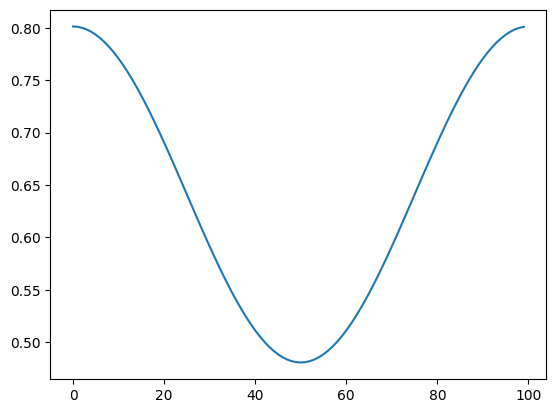

In [4]:
x0 = np.concatenate([q0, v0])  # Initial state
N = 100
dt = 0.02

# Define the reference trajectory to follow
pin.centerOfMass(model, data, q0, compute_subtree_coms=False)
highest = data.com[0][2]
lowest = data.com[0][2] * 0.6
mean_com = (highest + lowest) / 2.0
amplitude = (highest - lowest) / 2.0
traj = [mean_com + amplitude * np.cos(2* np.pi * t / N) for t in range(N)]

plt.figure()
plt.plot(traj)

In [5]:
# Build running models
running_models = []

for t in range(N-1):
    state = croc.StateMultibody(model)
    actuation = croc.ActuationModelFloatingBase(state)

    # Contacts
    contacts = croc.ContactModelMultiple(state, actuation.nu)
    for cid, placement in zip([right_foot_id, left_foot_id], [oMright_foot, oMleft_foot]):
        contact = croc.ContactModel6D(
            state,
            cid,
            placement,
            pin.ReferenceFrame.LOCAL_WORLD_ALIGNED,
            actuation.nu,
            np.array([200.0, 20.0])
        )
        contacts.addContact(f"{model.frames[cid]}_contact", contact)
    # Costs
    costs = croc.CostModelSum(state, actuation.nu)
    # State regularization
    xRegResidual = croc.ResidualModelState(state, x0, actuation.nu)
    xRegCost = croc.CostModelResidual(
        state,
        croc.ActivationModelWeightedQuad(np.concatenate((np.zeros(nv), np.ones(nv)))),
        xRegResidual,
    )
    if weights["x_reg"] > 0.0:
        costs.addCost("xReg", xRegCost, weights["x_reg"])
    # Control regularization
    uRegResidual = croc.ResidualModelControl(state, actuation.nu)
    uRegCost = croc.CostModelResidual(
        state,
        croc.ActivationModelWeightedQuad(np.ones(actuation.nu)),
        uRegResidual,
    )
    if weights["u_reg"] > 0.0:
        costs.addCost("uReg", uRegCost, weights["u_reg"])
    # Reference trajectory tracking
    comTrackResidual = croc.ResidualModelCoMPosition(state, np.array([0, 0, traj[t]]), actuation.nu)
    comTrackCost = croc.CostModelResidual(
        state,
        croc.ActivationModelWeightedQuad(np.array([0, 0, 1.0])),
        comTrackResidual,
    )
    if weights["com_track"] > 0.0:
        costs.addCost("xRef", comTrackCost, weights["com_track"])

    # Action model
    am = croc.IntegratedActionModelEuler(
        croc.DifferentialActionModelContactFwdDynamics(
            state,
            actuation,
            contacts,
            costs,
        ),
        dt
    )
    running_models.append(am)

# Build the terminal model
contacts = croc.ContactModelMultiple(state, actuation.nu)
for cid in [right_foot_id, left_foot_id]:
    contact = croc.ContactModel6D(
        state,
        cid,
        pin.SE3.Identity(),
        pin.ReferenceFrame.LOCAL_WORLD_ALIGNED,
        actuation.nu,
        np.array([0.0, 10.0])
    )
    contacts.addContact(f"{model.frames[cid]}_contact", contact)
# Costs
costs = croc.CostModelSum(state, actuation.nu)
# State regularization
xRegResidual = croc.ResidualModelState(state, x0, actuation.nu)
xRegCost = croc.CostModelResidual(
    state,
    croc.ActivationModelWeightedQuad(np.ones(ndx)),
    xRegResidual,
)
if weights["x_reg_term"] > 0.0:
    costs.addCost("xReg", xRegCost, weights["x_reg_term"])
# Action model
dam = croc.DifferentialActionModelContactFwdDynamics(
    state,
    actuation,
    contacts,
    costs,
)
terminal_model = croc.IntegratedActionModelEuler(
    dam,
    dt
)

In [6]:
# Define the shooting problem
problem = croc.ShootingProblem(
    x0=x0,
    runningModels=running_models,
    terminalModel=terminal_model,
)
ddp = croc.SolverFDDP(problem)
ddp.th_stop = 1e-6
ddp.setCallbacks([croc.CallbackLogger(), croc.CallbackVerbose()])

xs_init = [x0] * N
us_init = [np.zeros(model.nv - 6)] * (N - 1)
#xs_init = problem.rollout(us_init)

print("Starting DDP optimization...")
ddp.solve(xs_init, us_init, 100)
#ddp.solve()

Starting DDP optimization...
iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  1.644e-02  0.000e+00  2.611e-02  3.204e-02  1.000e-09  1.000e-09  0.5000  9.657e-01  0.000e+00  0.000e+00  1.854e-02  2.208e-02  0.000e+00  0.000e+00
   1  1.381e-02  0.000e+00  7.238e-04  4.203e-03  1.000e-09  1.000e-09  0.5000  4.829e-01  0.000e+00  0.000e+00  2.107e-03  2.626e-03  0.000e+00  0.000e+00
   2  1.611e-02  0.000e+00  2.285e-03  3.337e-04  1.000e-09  1.000e-09  1.0000  2.414e-01  0.000e+00  0.000e+00 -2.285e-03 -2.300e-03  0.000e+00  0.000e+00
   3  1.597e-02  0.000e+00  1.150e-04  2.301e-04  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.150e-04  1.434e-04  0.000e+00  0.000e+00
   4  1.595e-02  0.000e+00  1.189e-05  2.378e-05  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.189e-05  1.955e-05  0.000e+00  0.000e+00
   5  1.594e-02  0.000e+00  5.962e-06 

True

In [7]:
viz.display(q0)
viz.viewer.jupyter_cell()

In [8]:
xs_sol = np.array(ddp.xs)
us_sol = np.array(ddp.us)

# Visualize the solution
for i in range(len(xs_sol)):
    viz.display(xs_sol[i, :nq])
    time.sleep(dt)


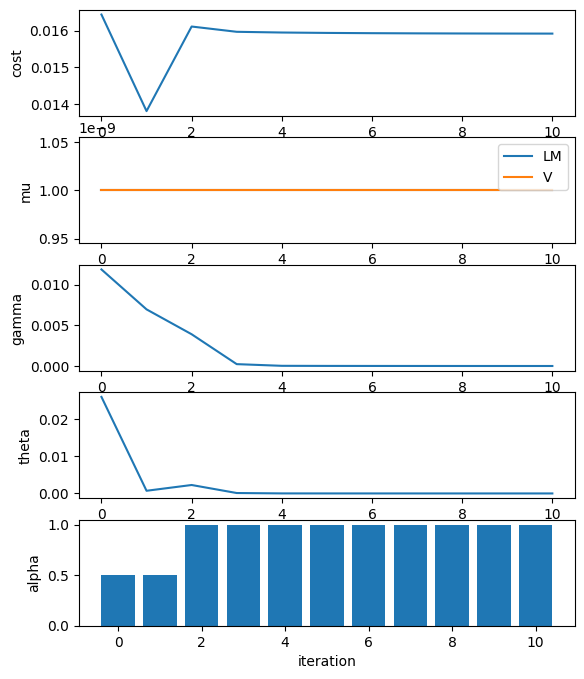

In [9]:
log = ddp.getCallbacks()[0]

croc.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)

## MPPI

In [20]:
# MPPI parameters
from MPPI.mppi import MPPI, MPPILogger
from MPPI.mppi_ddp import MPPIDDP

horizon = 10 # 50 # 10       # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 1    # Temperature parameter
noise_std = np.full(21, 0.001)
n_iter = 50
# Logging
logger_mppi_ddp = MPPILogger(enable_logging=True, n_log=5)
problem = croc.ShootingProblem(
    x0=x0,
    runningModels=running_models[:horizon],
    terminalModel=terminal_model,
)

# Initial state for the unicycle: [x, y, yaw]
# x0 = robot_model.x0

print("Running MPPI solver...")
mppi_ddp_solver = MPPIDDP(running_models[0], terminal_model, horizon, num_samples, lambda_param, noise_std,
                   param_exploration=0.0, n_filt=1, logger=logger_mppi_ddp,
                   ddp_problem = problem)

u_opt_mppi_ddp = mppi_ddp_solver.solve(x0, n_iter)
# u_opt_mppi_ddp = mppi_ddp_solver.solve_receding_horizon(x0, 200)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi, mppi_final_cost = mppi_ddp_solver.rollout_trajectory(x0, u_opt_mppi_ddp)
# Store the final optimized nominal control sequence in the logger
logger_mppi_ddp.set_final_controls(u_opt_mppi_ddp)
logger_mppi_ddp.set_final_state(x_opt_mppi)

print(f"Final cost of optimal trajectory: {mppi_final_cost:.4f}")

Running MPPI solver...
Iteration 1/50, Min Cost: 0.1190, Mean Cost: 0.6351, DDP Cost: 0.1190, DDP converged: False
Iteration 2/50, Min Cost: 0.1155, Mean Cost: 0.6195, DDP Cost: 0.1155, DDP converged: False
Iteration 3/50, Min Cost: 0.1121, Mean Cost: 0.6045, DDP Cost: 0.1121, DDP converged: False
Iteration 4/50, Min Cost: 0.1086, Mean Cost: 0.5899, DDP Cost: 0.1086, DDP converged: False
Iteration 5/50, Min Cost: 0.1052, Mean Cost: 0.5758, DDP Cost: 0.1052, DDP converged: False
Iteration 6/50, Min Cost: 0.1019, Mean Cost: 0.5621, DDP Cost: 0.1019, DDP converged: False
Iteration 7/50, Min Cost: 0.0986, Mean Cost: 0.5488, DDP Cost: 0.0986, DDP converged: False
Iteration 8/50, Min Cost: 0.0953, Mean Cost: 0.5360, DDP Cost: 0.0953, DDP converged: False
Iteration 9/50, Min Cost: 0.0921, Mean Cost: 0.5235, DDP Cost: 0.0921, DDP converged: False
Iteration 10/50, Min Cost: 0.0890, Mean Cost: 0.5114, DDP Cost: 0.0890, DDP converged: False
Iteration 11/50, Min Cost: 0.0860, Mean Cost: 0.4996, DD

In [18]:
viz.display(q0)
viz.viewer.jupyter_cell()

In [19]:
nu = 21
u_random = np.random.multivariate_normal(
                np.zeros(nu),
                np.diag(noise_std**2),
                size=(10,)
            )
x, cost = mppi_solver.rollout_trajectory(x0, u_random)
print(cost)

0.640331359161644


In [20]:
# Visualize the solution
for i in range(len(x)):
    viz.display(x[i, :nq])
    time.sleep(dt)


(0.0, 10.0)

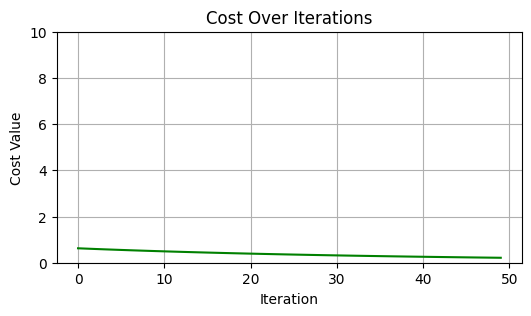

In [21]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_cost(logger_mppi_ddp.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_cost(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_cost(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_ylim(10, 50)